In [183]:
import sys
sys.path.append('..')
from auto_eval import bootstrap_kappa
import numpy as np
import json
from google.cloud import bigquery
from google.cloud.bigquery import dbapi
import pandas as pd
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../mykeys/grolleau_application_default_credentials.json'
os.environ['GCLOUD_PROJECT'] = 'som-nero-phi-jonc101'

In [184]:
#evaluated_model = "GPT-4o" # or "Deepseek-R1" 
evaluated_model = "Deepseek-R1" 
evaluated_model.lower()

'deepseek-r1'

In [185]:
def load_res_from_json(json_file=f"../jsons/llm_eval_results_{evaluated_model.lower()}.json"):    
    # Load the JSON file
    with open(json_file, "r") as f:
        llm_eval_results = json.load(f)

    # Extract distinct lists from the JSON data
    llms_evaluators_names = llm_eval_results["llms_evaluators_names"]
    times_per_patient = llm_eval_results["times_per_patient"]
    llm_scores_mat_results = llm_eval_results["llm_scores_mat_results"] 
    kappa_results = llm_eval_results["kappa_results"]
    kappa_ci_results = llm_eval_results["kappa_ci_results"]
    evaluated_model = llm_eval_results["evaluated_model"]
    
    # print all for sanity check
    print("llms_evaluators_names: ", llms_evaluators_names)
    print("times_per_patient: ", times_per_patient)
    print("llm_scores_mat_results: ", llm_scores_mat_results)
    print("kappa_results: ", kappa_results)
    print("kappa_ci_results: ", kappa_ci_results)
    print("evaluated_model: ", evaluated_model)
    
    ### Sort the results by alphabetical order of llms_evaluators_names

    # Create a list of tuples with all the data
    combined_data = list(zip(times_per_patient, llm_scores_mat_results, kappa_results, kappa_ci_results, llms_evaluators_names))

    # Sort by  by alphabetical order of llms_evaluators_names
    sorted_data = sorted(combined_data, key=lambda x: x[4])

    # Unzip the sorted data back into separate lists
    times_per_patient, llm_scores_mat_results, kappa_results, kappa_ci_results, llms_evaluators_names = map(list, zip(*sorted_data))

    single_phy_idx  = llms_evaluators_names.index("Single Physician")
    llms_evaluators_names = [llms_evaluators_names[single_phy_idx]] +  [cont for i, cont in enumerate(llms_evaluators_names) if i != single_phy_idx]
    times_per_patient = [times_per_patient[single_phy_idx]] +  [cont for i, cont in enumerate(times_per_patient) if i != single_phy_idx]
    llm_scores_mat_results = [llm_scores_mat_results[single_phy_idx]] +  [cont for i, cont in enumerate(llm_scores_mat_results) if i != single_phy_idx]
    kappa_results = [kappa_results[single_phy_idx]] +  [cont for i, cont in enumerate(kappa_results) if i != single_phy_idx]
    kappa_ci_results = [kappa_ci_results[single_phy_idx]] +  [cont for i, cont in enumerate(kappa_ci_results) if i != single_phy_idx]

    # print all for sanity check
    print("llms_evaluators_names: ", llms_evaluators_names)
    print("times_per_patient: ", times_per_patient)
    print("llm_scores_mat_results: ", llm_scores_mat_results)
    print("kappa_results: ", kappa_results)
    print("kappa_ci_results: ", kappa_ci_results)
    print("evaluated_model: ", evaluated_model)
    
    return llms_evaluators_names, times_per_patient, llm_scores_mat_results, kappa_results, kappa_ci_results, evaluated_model

In [186]:
llms_evaluators_names, times_per_patient, llm_scores_mat_results, kappa_results, kappa_ci_results, evaluated_model = load_res_from_json(f"../jsons/llm_eval_results_{evaluated_model.lower()}.json")

llms_evaluators_names:  ['Single Physician', 'Claude 3.5 v2', 'GPT-4.1', 'Llama 4 Scout', 'Llama 4 Maverick', 'Deepseek-R1', 'Claude 3.7', 'Gemini 2 Flash Exp', 'Gemini 2.5 Pro Preview', 'Phi 3.5', 'GPT-4.1 nano']
times_per_patient:  [928.890625, 24.275904504458108, 9.458764497439066, 15.374739694595338, 11.507836310068766, 34.53408700625102, 37.61436642805735, 14.529645133018494, 34.94462776184082, 28.429029130935668, 6.458261871337891]
llm_scores_mat_results:  [[[1, 1, 1], [1, 1, 1], [1, 0, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 0, 1], [1, 0, 1], [1, 0, 1], [0, 1, 1], [1, 1, 0], [1, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 1], [0, 1, 0], [1, 1, 1], [1, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0], [1, 0, 1], [1, 0, 0], [1, 1, 1], [1, 1, 0], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 0], [1, 0, 1]], [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 0.0, 1.0], [1.0, 1.0, 1.0], [0.0, 1.0, 0.0], [1.0, 1.0, 1.0], [0.0, 0.0, 1.0], [1.0, 0.0, 1.0], [1.0, 0.0, 1.0], [0.0, 1.0, 1.0], [1.0, 1.0, 0.0], [1.0, 1.0, 1

In [187]:
len(llms_evaluators_names), len(times_per_patient), len(llm_scores_mat_results), len(kappa_results), len(kappa_ci_results)

(11, 11, 11, 11, 11)

In [188]:
bootstrap_kappa(np.array(llm_scores_mat_results[1]).flatten(), np.array(llm_scores_mat_results[0]).flatten(), n_boot=0)

np.float64(0.7257617728531855)

In [189]:
#### Get human evaluation scores
client = bigquery.Client()
conn = dbapi.connect(client)

#  remove duplicates and select only the clinicians who completed the task    
querry = f"""
WITH rn_table AS (
  SELECT
    *,
    ROW_NUMBER() OVER (                 
      PARTITION BY username, doc_id, prototype
      ORDER BY review_duration_seconds
    ) AS rn
  FROM som-nero-phi-jonc101.flask_eval.response
  WHERE prototype = '{evaluated_model}'
),

no_dup_submition_tab AS (           
  SELECT *
  FROM rn_table
  WHERE rn = 1
)

SELECT *
FROM no_dup_submition_tab
QUALIFY COUNT(*) OVER (PARTITION BY username) = 30;
"""

human_res = pd.read_sql_query(querry, conn)

human_res['fact0_score'] = human_res['fact1_included'].apply(lambda x: 1 if x == "Yes" else 0)  # Convert for fact 0
human_res['fact1_score'] = human_res['fact2_included'].apply(lambda x: 1 if x == "Yes" else 0)  # Convert for fact 1
human_res['fact2_score'] = human_res['fact3_included'].apply(lambda x: 1 if x == "Yes" else 0)  # Convert for fact 2


/var/folders/g9/0793jttd561450xdx_49841c0000gq/T/ipykernel_58622/2538347661.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  human_res = pd.read_sql_query(querry, conn)


In [190]:
human_res = human_res[['doc_id', 'username', 'fact0_score', 'fact1_score', 'fact2_score']].sort_values(by=['doc_id', 'username'])
human_res

,doc_id,username,fact0_score,fact1_score,fact2_score
96,1,asliang,1,1,1
66,1,clin01,1,1,1
11,1,htridu,1,1,1
179,1,nzsteele,1,1,1
35,1,tlew,1,1,1
...,...,...,...,...,...
25,30,htridu,1,0,1
155,30,nzsteele,1,0,0
43,30,tlew,1,0,1
140,30,wchu1,1,0,1


In [191]:
# get a list of unique usernames
unique_usernames = list(human_res['username'].unique())
unique_usernames

['asliang', 'clin01', 'htridu', 'nzsteele', 'tlew', 'wchu1', 'yginger']

In [192]:
# Step 1: Convert from wide format (for facts) to long format
long_df = pd.melt(
    human_res,
    id_vars=['doc_id', 'username'],
    value_vars=['fact0_score', 'fact1_score', 'fact2_score'],
    var_name='fact_type',
    value_name='score'
)

long_df

,doc_id,username,fact_type,score
0,1,asliang,fact0_score,1
1,1,clin01,fact0_score,1
2,1,htridu,fact0_score,1
3,1,nzsteele,fact0_score,1
4,1,tlew,fact0_score,1
...,...,...,...,...
625,30,htridu,fact2_score,1
626,30,nzsteele,fact2_score,0
627,30,tlew,fact2_score,1
628,30,wchu1,fact2_score,1


In [193]:
# Extract numeric fact number
long_df['fact_no'] = long_df['fact_type'].str.extract('(\d+)').astype(int)
long_df = long_df.drop('fact_type', axis=1)

long_df

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/var/folders/g9/0793jttd561450xdx_49841c0000gq/T/ipykernel_58622/3480722943.py:2: SyntaxWarning: invalid escape sequence '\d'
  long_df['fact_no'] = long_df['fact_type'].str.extract('(\d+)').astype(int)


,doc_id,username,score,fact_no
0,1,asliang,1,0
1,1,clin01,1,0
2,1,htridu,1,0
3,1,nzsteele,1,0
4,1,tlew,1,0
...,...,...,...,...
625,30,htridu,1,2
626,30,nzsteele,0,2
627,30,tlew,1,2
628,30,wchu1,1,2


In [194]:
# Step 2: Pivot to create columns for each user
user_wide_df = long_df.pivot_table(
    index=['fact_no', 'doc_id'],
    columns='username',
    values='score'
).reset_index()

user_wide_df = user_wide_df.sort_values(by=['doc_id', 'fact_no']).reset_index(drop=True)
user_wide_df

username,fact_no,doc_id,asliang,clin01,htridu,nzsteele,tlew,wchu1,yginger
0,0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
85,1,29,1.0,0.0,1.0,1.0,0.0,1.0,1.0
86,2,29,1.0,0.0,0.0,0.0,0.0,0.0,0.0
87,0,30,1.0,1.0,1.0,1.0,1.0,1.0,1.0
88,1,30,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [195]:
flat_llm_res = np.hstack([np.array(llm_scores_mat_results[i]).reshape(-1,1) for i in range(len(llm_scores_mat_results))])
flat_llm_res

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [196]:
# explictly calculate the majority vote from humans 
1 * (np.mean(user_wide_df.iloc[:, 2:], axis=1)>.5)

0     1
1     1
2     1
3     1
4     1
     ..
85    1
86    0
87    1
88    0
89    1
Length: 90, dtype: int64

In [197]:
# Check that majority vote from humans corresponds in the first column flat_llm_res and explict calculation on user_wide_df
all(flat_llm_res[:,0] == 1 * (np.mean(user_wide_df.iloc[:, 2:], axis=1)>.5))

True

In [198]:
# Add a column for the LLM jury (majority vote of all LLMs)
flat_llm_res = np.hstack([flat_llm_res, 1*(np.mean(flat_llm_res[:,1:], axis=1)>=0.5).reshape(-1,1)])

In [199]:
# USER CONFIGURATION: Select LLM judges for custom jury
# Available LLM judges (excluding "Single Physician"):
available_llm_judges = [name for name in llms_evaluators_names if name != "Single Physician"]
print("Available LLM judges:")
for i, judge in enumerate(available_llm_judges):
    print(f"{i}: {judge}")

# USER: Modify this list to select which LLM judges to include in the 
# jury
# Example: Select Llama 4 Maverick, GPT-4.1, Deepseek-R1
selected_llm_indices = [7, 3, 2]  # Modify this list as needed

# Get the selected LLM judge names
selected_llm_judges = [available_llm_judges[i] for i in selected_llm_indices]
print(f"\nSelected LLM judges for custom jury: {selected_llm_judges}")

Available LLM judges:
0: Claude 3.5 v2
1: Claude 3.7
2: Deepseek-R1
3: GPT-4.1
4: GPT-4.1 nano
5: Gemini 2 Flash Exp
6: Gemini 2.5 Pro Preview
7: Llama 4 Maverick
8: Llama 4 Scout
9: Phi 3.5

Selected LLM judges for custom jury: ['Llama 4 Maverick', 'GPT-4.1', 'Deepseek-R1']


In [200]:
# Calculate custom LLM jury majority vote
# Get indices of selected LLMs in the original llms_evaluators_names list
selected_llm_original_indices = [llms_evaluators_names.index(judge) for judge in selected_llm_judges]

# Extract scores for selected LLMs (excluding Single Physician which is at index 0)
selected_llm_scores = flat_llm_res[:, [idx for idx in selected_llm_original_indices if idx != 0]]

# Calculate majority vote for custom jury
custom_jury_scores = 1 * (np.mean(selected_llm_scores, axis=1) >= 0.5)

# Add custom jury to flat_llm_res
flat_llm_res = np.hstack([flat_llm_res, custom_jury_scores.reshape(-1,1)])

print(f"Custom jury created from {len(selected_llm_judges)} LLM judges")

Custom jury created from 3 LLM judges


In [201]:
llm_names_with_single_physician_and_jury = llms_evaluators_names + ["LLM Jury"] + ["Custom LLM Jury"]

# Convert flat_llm_res to a DataFrame with column names from llms_evaluators_names
llm_df = pd.DataFrame(flat_llm_res, columns=llm_names_with_single_physician_and_jury)

# Get the same index as user_wide_df to ensure proper alignment
llm_df.index = user_wide_df.index

# Combine the DataFrames horizontally
combined_df = pd.concat([user_wide_df, llm_df], axis=1)

# If you want to avoid duplicate columns (in case there's overlap between usernames and LLM names)
# First reset index to make fact_no and doc_id regular columns again
combined_df = combined_df.reset_index(drop=True)

# Display the combined result
combined_df

,fact_no,doc_id,asliang,clin01,htridu,nzsteele,tlew,wchu1,yginger,Single Physician,...,Deepseek-R1,GPT-4.1,GPT-4.1 nano,Gemini 2 Flash Exp,Gemini 2.5 Pro Preview,Llama 4 Maverick,Llama 4 Scout,Phi 3.5,LLM Jury,Custom LLM Jury
0,0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1,29,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,2,29,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,0,30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
88,1,30,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [202]:
flatten_user_scores = combined_df[unique_usernames]
flatten_user_scores

,asliang,clin01,htridu,nzsteele,tlew,wchu1,yginger
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
85,1.0,0.0,1.0,1.0,0.0,1.0,1.0
86,1.0,0.0,0.0,0.0,0.0,0.0,0.0
87,1.0,1.0,1.0,1.0,1.0,1.0,1.0
88,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [203]:
user_kappas = []
for user in unique_usernames:
    user_i = flatten_user_scores[user]
    other_users = flatten_user_scores.drop(user, axis=1)
    majority_from_other_users = 1*(np.mean(other_users, axis=1)>.5)
    user_kappa = bootstrap_kappa(user_i, majority_from_other_users, n_boot=0)
    print(f"User: {user}, Kappa: {user_kappa}")
    user_kappas.append(user_kappa)
    
user_mean_kappa = np.mean(user_kappas)
print(f"Mean Kappa for all users: {user_mean_kappa}")

User: asliang, Kappa: 0.7295673076923077
User: clin01, Kappa: 0.6610169491525424
User: htridu, Kappa: 0.7732997481108312
User: nzsteele, Kappa: 0.8448275862068966
User: tlew, Kappa: 0.7356051703877791
User: wchu1, Kappa: 0.6336499321573947
User: yginger, Kappa: 0.7245409015025042
Mean Kappa for all users: 0.7289296564586081


In [204]:
flatten_llm_scores = combined_df[llm_names_with_single_physician_and_jury].drop("Single Physician", axis=1)
flatten_llm_scores

,Claude 3.5 v2,Claude 3.7,Deepseek-R1,GPT-4.1,GPT-4.1 nano,Gemini 2 Flash Exp,Gemini 2.5 Pro Preview,Llama 4 Maverick,Llama 4 Scout,Phi 3.5,LLM Jury,Custom LLM Jury
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
88,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [205]:
majority_from_all_users = combined_df["Single Physician"]

In [206]:
llm_evaluator = "Llama 4 Maverick"

llm_kappa = bootstrap_kappa(flatten_llm_scores[llm_evaluator], majority_from_all_users, n_boot=0)

In [207]:
llm_kappa - user_mean_kappa

np.float64(-0.05325398078293242)

In [208]:
def agreement_diff(combined_df, llm_evaluator):
    flatten_user_scores = combined_df[unique_usernames]

    user_kappas = []
    for user in unique_usernames:
        user_i = flatten_user_scores[user]
        other_users = flatten_user_scores.drop(user, axis=1)
        majority_from_other_users = 1*(np.mean(other_users, axis=1)>.5)
        user_kappa = bootstrap_kappa(user_i, majority_from_other_users, n_boot=0)
        user_kappas.append(user_kappa)
        
    user_mean_kappa = np.mean(user_kappas)

    flatten_llm_scores = combined_df[llm_names_with_single_physician_and_jury].drop("Single Physician", axis=1)
    majority_from_all_users = combined_df["Single Physician"]
    llm_kappa = bootstrap_kappa(flatten_llm_scores[llm_evaluator], majority_from_all_users, n_boot=0)

    return llm_kappa - user_mean_kappa

In [209]:
llm_names_with_jury = llm_names_with_single_physician_and_jury[1:]

In [210]:
for llm_name in llm_names_with_jury:
    print(f"LLM: {llm_name}, Agreement Difference: {agreement_diff(combined_df, llm_name)}")

LLM: Claude 3.5 v2, Agreement Difference: -0.003167883605422528
LLM: Claude 3.7, Agreement Difference: -0.14538209861799112
LLM: Deepseek-R1, Agreement Difference: -0.07957900710795873
LLM: GPT-4.1, Agreement Difference: -0.024820067417512193
LLM: GPT-4.1 nano, Agreement Difference: -0.3080181283084741
LLM: Gemini 2 Flash Exp, Agreement Difference: -0.1724079173281733
LLM: Gemini 2.5 Pro Preview, Agreement Difference: -0.1823301602369456
LLM: Llama 4 Maverick, Agreement Difference: -0.05325398078293242
LLM: Llama 4 Scout, Agreement Difference: -0.03838524385115827
LLM: Phi 3.5, Agreement Difference: -0.25320150111880224
LLM: LLM Jury, Agreement Difference: 0.018969503205257476
LLM: Custom LLM Jury, Agreement Difference: -0.024820067417512193


In [211]:
def bootstrap_agreement_diff(combined_df, llm_name, n_boot=9999, random_seed=42):
    """
    Bootstrap the agreement difference function using NumPy
    """
    np.random.seed(random_seed)
    n_samples = len(combined_df)
    boot_res = []
    
    for _ in range(n_boot):
        # Sample with replacement
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        resampled_df = combined_df.iloc[indices]
        boot_res.append(agreement_diff(resampled_df, llm_name))
    
    # Get results
    mean_diff = agreement_diff(combined_df, llm_name)
    ci = np.percentile(boot_res, [5, 95])
    
    return mean_diff, ci, boot_res

In [212]:
all_mean_diff = []
all_ci = []
all_boot = []
for llm_name in llm_names_with_jury:
    mean_diff, ci, boot_res = bootstrap_agreement_diff(combined_df, llm_name, random_seed=42)
    all_mean_diff.append(mean_diff)
    all_ci.append(ci)
    all_boot.append(boot_res)
    print(f"LLM: {llm_name}, Original stat: {100*mean_diff:.2f}%, 90% CI: [{100*ci[0]:.2f}%, {100*ci[1]:.2f}%]")

LLM: Claude 3.5 v2, Original stat: -0.32%, 90% CI: [-12.36%, 11.67%]
LLM: Claude 3.7, Original stat: -14.54%, 90% CI: [-27.42%, -1.39%]
LLM: Deepseek-R1, Original stat: -7.96%, 90% CI: [-19.70%, 3.93%]
LLM: GPT-4.1, Original stat: -2.48%, 90% CI: [-14.53%, 9.33%]
LLM: GPT-4.1 nano, Original stat: -30.80%, 90% CI: [-45.96%, -15.70%]
LLM: Gemini 2 Flash Exp, Original stat: -17.24%, 90% CI: [-32.38%, -2.72%]
LLM: Gemini 2.5 Pro Preview, Original stat: -18.23%, 90% CI: [-30.85%, -5.74%]
LLM: Llama 4 Maverick, Original stat: -5.33%, 90% CI: [-19.11%, 7.77%]
LLM: Llama 4 Scout, Original stat: -3.84%, 90% CI: [-16.75%, 8.54%]
LLM: Phi 3.5, Original stat: -25.32%, 90% CI: [-41.48%, -9.88%]
LLM: LLM Jury, Original stat: 1.90%, 90% CI: [-9.48%, 13.17%]
LLM: Custom LLM Jury, Original stat: -2.48%, 90% CI: [-14.03%, 9.16%]


In [213]:
def non_inf_p_value(boot_res, ni_threshold):
    """
    Calculate the non-inferiority p-value from the bootstrap results and the non-inferiority threshold
    """
    p_val = (np.array(boot_res) < ni_threshold).mean()
    if bool(p_val == 0):
        from scipy import stats
        boot_mean = np.mean(boot_res)
        boot_std = np.std(boot_res)
        p_val = stats.norm.cdf(ni_threshold, loc=boot_mean, scale=boot_std)
        return p_val
    else:
        return p_val

In [214]:
ni_threshold = -0.1
p_val = (np.array(boot_res) < ni_threshold).mean()
if bool(p_val == 0):
    from scipy import stats
    boot_mean = np.mean(boot_res)
    boot_std = np.std(boot_res)
    p_val = stats.norm.cdf(ni_threshold, loc=boot_mean, scale=boot_std)

In [215]:
ni_threshold = -0.1
all_p_values = [non_inf_p_value(boot_res, ni_threshold) for boot_res in all_boot]
all_p_values

[np.float64(0.09000900090009001),
 np.float64(0.7191719171917191),
 np.float64(0.3838383838383838),
 np.float64(0.14641464146414643),
 np.float64(0.9867986798679867),
 np.float64(0.7901790179017901),
 np.float64(0.8621862186218622),
 np.float64(0.26832683268326835),
 np.float64(0.2153215321532153),
 np.float64(0.9483948394839484),
 np.float64(0.043704370437043706),
 np.float64(0.141014101410141)]

In [216]:
llm_names_with_jury

['Claude 3.5 v2',
 'Claude 3.7',
 'Deepseek-R1',
 'GPT-4.1',
 'GPT-4.1 nano',
 'Gemini 2 Flash Exp',
 'Gemini 2.5 Pro Preview',
 'Llama 4 Maverick',
 'Llama 4 Scout',
 'Phi 3.5',
 'LLM Jury',
 'Custom LLM Jury']

In [217]:
# Reorder data based on all_mean_diff values fpr visualization from worst to best LLM judge (top to bottom)

# Combine the lists into a list of tuples
combined_for_sorting = list(zip(all_mean_diff, all_ci, llm_names_with_jury, all_boot))

# Sort the combined list based on the mean_diff values (the first element of each tuple)
# To sort in descending order (largest mean_diff first), use reverse=True
# To sort in ascending order (smallest mean_diff first), use reverse=False (default)
# Let's assume ascending order for now.
sorted_combined = sorted(combined_for_sorting, key=lambda x: x[0]) 

# Unzip the sorted list back into individual lists
all_mean_diff_sorted, all_ci_sorted, llm_names_with_jury_sorted, all_boot_sorted = map(list, zip(*sorted_combined))

# Now, recalculate all_p_values based on the sorted all_boot_sorted
# Make sure ni_threshold is defined
all_p_values_sorted = [non_inf_p_value(boot_res, ni_threshold) for boot_res in all_boot_sorted]

# Replace the original lists with the sorted ones for the plot
all_mean_diff = all_mean_diff_sorted
all_ci = all_ci_sorted
llm_names_with_jury = llm_names_with_jury_sorted
all_p_values = all_p_values_sorted

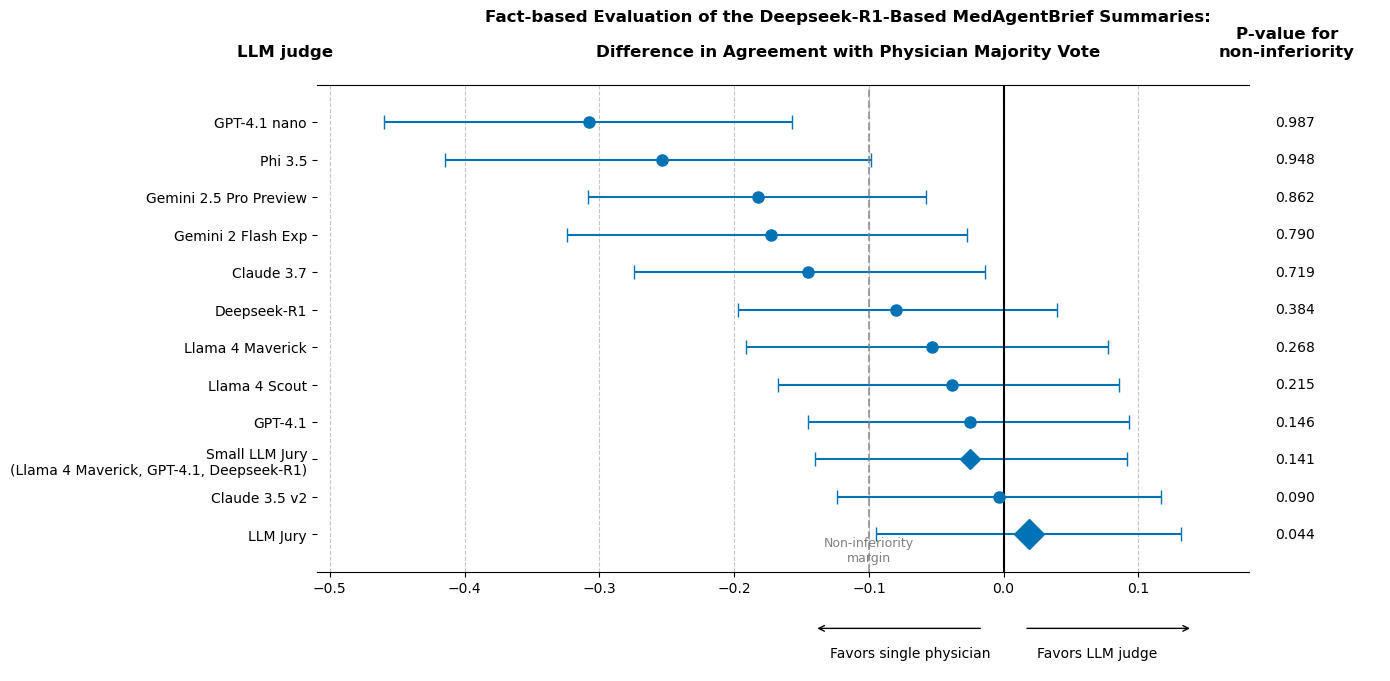

In [218]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Set up the figure with gridspec for better control of layout
fig = plt.figure(figsize=(14, 8))
# Define width and height ratios for GridSpec
height_ratios = [0.2, 4, 0.5] # Title, Main Plot, Arrows
width_ratios = [8, 1]      # Main Plot, P-values
gs = gridspec.GridSpec(3, 2, height_ratios=height_ratios, width_ratios=width_ratios)

# Create axes
title_ax = plt.subplot(gs[0, :])  # Title area spans both columns
main_ax = plt.subplot(gs[1, 0])   # Main plot area
p_val_ax = plt.subplot(gs[1, 1])  # P-values area (right of main plot)
arrow_ax = plt.subplot(gs[2, 0])  # Arrows area (below main plot)

# Hide axes frames and ticks where not needed
title_ax.axis('off')
p_val_ax.axis('off')
arrow_ax.axis('off')

# --- Titles and Labels on title_ax ---
# Calculate sum of width ratios for positioning
sum_wr = sum(width_ratios)

# Main title
title_ax.text(0.5, 0.5, f"Fact-based Evaluation of the {evaluated_model}-Based MedAgentBrief Summaries:\n\nDifference in Agreement with Physician Majority Vote", 
              ha='center', va='center', fontsize=12, fontweight='bold')

# "LLM judge" label on the left of title_ax
# Adjust x-coordinate for alignment with main_ax y-tick labels if necessary
# (0.0 might be too far left, 0.01 or similar might be better depending on figure padding)
title_ax.text(-0.075, 0.5, "\n\nLLM judge", 
              fontweight='bold', ha='left', va='center', fontsize=12)

# "P-value" label on title_ax, aligned with where p-values start in p_val_ax
# p_val_ax starts at width_ratios[0]/sum_wr relative x-position.
# P-values text in p_val_ax was at 0.1 relative to p_val_ax's own width.
title_ax.text(.9125, 0.5, "\nP-value for\nnon-inferiority", 
              fontweight='bold', ha='center', va='center', fontsize=12)

# --- Main Plot (main_ax) ---
# Number of LLMs to plot
n_llms = len(llm_names_with_jury)

# Y positions for each LLM (reversed order to have first item at top)
y_pos = np.arange(n_llms, 0, -1) # From n_llms down to 1

# Plot mean differences and CIs in main plot
for i, (mean_diff, ci) in enumerate(zip(all_mean_diff, all_ci)):
    # Default marker settings
    marker_style = 'o'
    marker_size = 8
    marker_color = '#0072B5'

    # Check if it's the LLM Jury (large diamond)
    if llm_names_with_jury[i] == "LLM Jury":
        marker_style = 'D' # Diamond marker
        marker_size = 15   # Larger marker size
    # Check if it's the Custom LLM Jury (small diamond)
    elif llm_names_with_jury[i] == "Custom LLM Jury":
        marker_style = 'D' # Diamond marker
        marker_size = 10   # Smaller diamond than LLM Jury

    main_ax.errorbar(
        x=mean_diff, 
        y=y_pos[i], 
        xerr=[[mean_diff - ci[0]], [ci[1] - mean_diff]], 
        fmt=marker_style, 
        capsize=5, 
        color=marker_color, 
        markersize=marker_size
    )

# Add vertical line at non-inferiority threshold
main_ax.axvline(x=ni_threshold, color='gray', linestyle='--', alpha=0.7)
main_ax.text(ni_threshold, 0.2, "Non-inferiority\nmargin", 
       color='gray', ha='center', va='bottom', fontsize=9) # y=0.2 is relative to y_pos range

# Add solid vertical line at x=0 (line of no effect)
main_ax.axvline(x=0, color='black', linestyle='-')

# Modify frame: remove left and right spines, keep top and bottom
main_ax.spines['left'].set_visible(False)
main_ax.spines['right'].set_visible(False)
main_ax.spines['top'].set_visible(True)
main_ax.spines['bottom'].set_visible(True)

# Add LLM names on the left y-axis, with custom jury label showing selected judges
y_labels = []
for name in llm_names_with_jury:
    if name == "Custom LLM Jury":
        y_labels.append(f"Small LLM Jury\n({', '.join(selected_llm_judges)})")
    else:
        y_labels.append(name)

main_ax.set_yticks(y_pos)
main_ax.set_yticklabels(y_labels)

# Add grid lines for better readability on the x-axis
main_ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Set x-axis limits in main plot
min_x_data = min([ci[0] for ci in all_ci])
max_x_data = max([ci[1] for ci in all_ci])
min_x = min(min_x_data - 0.05, ni_threshold - 0.05)
max_x = max_x_data + 0.05 # Corrected line

main_ax.set_xlim(min_x, max_x)

# Set y-axis limits in main plot (to provide some padding)
main_ax.set_ylim(0, n_llms + 1) # From 0 to n_llms+1 to give space

# --- P-values Plot (p_val_ax) ---
# Ensure p_val_ax has the same y limits as main_ax for proper alignment
p_val_ax.set_ylim(main_ax.get_ylim()) # Match y-limits with main_ax

# Add p-values in the separate axis, aligned with LLMs
for i, p_val in enumerate(all_p_values):
    # Format p-value for display
    if p_val < 0.001:
        exponent = 0
        for exp_val in range(1, 100): 
            if p_val < 10**(-exp_val):
                exponent = -exp_val
            else:
                break 
        if exponent == 0: 
             p_text = f'{p_val:.3f}'
        else:
            p_text = r'$< 10^{{{}}}$'.format(exponent) # Not bold
    elif p_val < 0.01:
        p_text = f'{p_val:.3f}' # Not bold
    elif p_val < 0.05:
        p_text = f'{p_val:.3f}' # Not bold
    else:
        p_text = f'{p_val:.3f}' # Not bold
    p_val_ax.text(0.1, y_pos[i], p_text, va='center') # x=0.1 for slight indent

# --- Arrows Plot (arrow_ax) ---
# Calculate the relative horizontal position of the "line of no effect" (x=0 in main_ax)
# for arrow_ax (assuming arrow_ax's x-coordinates are 0 to 1 as its axis is off).
if (max_x - min_x) == 0: 
    x_line_of_no_effect_relative = 0.5 
else:
    x_line_of_no_effect_relative = (0 - min_x) / (max_x - min_x)

# Define appearance properties for arrows and text
y_pos_arrow_on_arrow_ax = 0.7  # Vertical position of the arrows in arrow_ax (0-1 scale)
y_pos_text_on_arrow_ax = 0.4   # Vertical position for the text labels (0-1 scale, below arrow)
arrow_segment_length_relative = 0.2 # Relative length of the arrow segment on arrow_ax

# Epsilon to prevent arrows from overlapping if they start at the exact same point
# and point in opposite directions (though here they start at line of no effect)
epsi = 0.025
# Right-pointing arrow (Favors LLM judge)
arrow_ax.annotate("", 
                  xy=(x_line_of_no_effect_relative + arrow_segment_length_relative, y_pos_arrow_on_arrow_ax), 
                  xytext=(x_line_of_no_effect_relative + epsi, y_pos_arrow_on_arrow_ax), 
                  arrowprops=dict(arrowstyle="->", color="black", shrinkA=0, shrinkB=0),
                  annotation_clip=False) 
arrow_ax.text(x_line_of_no_effect_relative + (arrow_segment_length_relative / 2), y_pos_text_on_arrow_ax, 
              "Favors LLM judge", ha='center', va='top')

# Left-pointing arrow (Favors Single physician)
arrow_ax.annotate("", 
                  xy=(x_line_of_no_effect_relative - arrow_segment_length_relative, y_pos_arrow_on_arrow_ax), 
                  xytext=(x_line_of_no_effect_relative - epsi, y_pos_arrow_on_arrow_ax), 
                  arrowprops=dict(arrowstyle="->", color="black", shrinkA=0, shrinkB=0),
                  annotation_clip=False)
arrow_ax.text(x_line_of_no_effect_relative - (arrow_segment_length_relative / 2), y_pos_text_on_arrow_ax, 
              "Favors single physician", ha='center', va='top')

# --- Final Adjustments ---
# Adjust layout to prevent overlapping elements
plt.tight_layout()
# Further adjust spacing if needed, especially vertical space between subplots
plt.subplots_adjust(hspace=0.2, top=1 - (height_ratios[0]/sum(height_ratios)) - 0.02, bottom=(height_ratios[2]/sum(height_ratios)) + 0.02)

# Save figure as PDF
output_path = f'../pdfs/noninf_forrest_{evaluated_model}.pdf'
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=300)

# Show plot
plt.show()